# Model of Classification Probability of Default

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.metrics import RocCurveDisplay
import scikitplot as skplt
from yellowbrick.classifier import discrimination_threshold

%config IPCompleter.greedy=True
pd.options.display.float_format = '{:.2f}'.format



In [11]:
import warnings
warnings.filterwarnings("ignore")

In [3]:

df  = pd.read_pickle('../../02_Data/03_Work/df_board_pd.pickle')

x = df.drop(columns = 'target_pd')
y = df.target_pd



## MODEL

In [7]:

train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.3) 


In [14]:
pipe = Pipeline([('algorythm',LogisticRegression())])

grid = [{'algorythm': [LogisticRegression(solver = 'saga', n_jobs=-1, max_iter=5000)],
         'algorythm__penalty': ['elasticnet', 'l1', 'l2'],
         'algorythm__C': [0,0.25,0.5,0.75,1]}
       ]

#### Optimize hyperparameters

In [15]:
grid_search = GridSearchCV(estimator= pipe, 
                           param_grid = grid, 
                           cv = 5, 
                           scoring = 'roc_auc',
                           verbose = 0,
                           n_jobs = -1)

model = grid_search.fit(train_x,train_y)

In [16]:
output = pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score').reset_index(drop=True).head(5)
output

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorythm,param_algorythm__C,param_algorythm__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,11.75,3.59,0.01,0.00,"LogisticRegression(max_iter=5000, n_jobs=-1, s...",1,l1,{'algorythm': LogisticRegression(max_iter=5000...,0.70,0.70,0.71,0.69,0.69,0.70,0.01,1
1,10.48,3.54,0.01,0.00,"LogisticRegression(max_iter=5000, n_jobs=-1, s...",0.75,l1,{'algorythm': LogisticRegression(max_iter=5000...,0.70,0.70,0.71,0.69,0.69,0.70,0.01,2
2,21.19,3.81,0.01,0.00,"LogisticRegression(max_iter=5000, n_jobs=-1, s...",1,l2,{'algorythm': LogisticRegression(max_iter=5000...,0.70,0.70,0.71,0.69,0.69,0.70,0.01,3
3,19.50,3.18,0.01,0.00,"LogisticRegression(max_iter=5000, n_jobs=-1, s...",0.75,l2,{'algorythm': LogisticRegression(max_iter=5000...,0.70,0.70,0.71,0.69,0.69,0.70,0.01,4
4,8.54,0.49,0.01,0.00,"LogisticRegression(max_iter=5000, n_jobs=-1, s...",0.50,l1,{'algorythm': LogisticRegression(max_iter=5000...,0.70,0.70,0.71,0.69,0.69,0.70,0.01,5


In [19]:
# 70% is the minimum acceptable
# 80% would be good, but 70 is ok.

In [20]:
# lasso forces the coeff to be 0
# so we prefer it, because we haven't done variable preselection

In [17]:
# use that best configuration

rl = LogisticRegression(solver = 'saga', n_jobs=-1, C = 1, penalty = 'l1')
rl.fit(train_x,train_y)

LogisticRegression(C=1, n_jobs=-1, penalty='l1', solver='saga')

In [18]:

coef = pd.DataFrame(data = rl.coef_, 
                    columns = rl.feature_names_in_).stack()\
.droplevel(level = 0).sort_values()

coef


interest_rate_mms                 -2.24
principal_mms                     -1.36
income_mms                        -1.08
purpose_house                     -0.29
dti_mms                           -0.28
verified_income_Not Verified      -0.28
num_installments_ 36 months       -0.25
housing_MORTGAGE                  -0.21
purpose_other                     -0.14
purpose_vacation                  -0.11
housing_OWN                       -0.10
purpose_car                       -0.08
purpose_credit_card               -0.05
verified_income_Source Verified   -0.04
purpose_moving                    -0.02
employment_duration_oe            -0.01
employment_duration_oe_mms         0.00
rating_oe_mms                      0.00
num_installments_ 60 months        0.00
purpose_debt_consolidation         0.02
purpose_medical                    0.02
purpose_home_improvement           0.03
housing_RENT                       0.06
verified_income_Verified           0.06
purpose_major_purchase             0.07


##### About the negatives

Principal and interest_rates have negative coefficients, so according to the model, the lower the amount you request, the greater the risk of default. 

Could happen, but we would need to investigate further. Here we will just leave it like this.



### Evaluate

In [21]:
pred = rl.predict_proba(val_x)[:,1]

In [22]:
roc_auc_score(val_y, pred)

0.7025236391407987

### Report

#### Gain chart

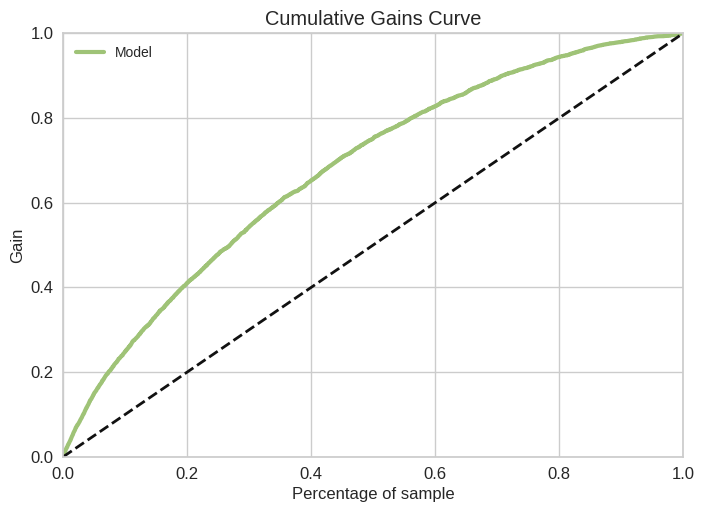

In [23]:
fig, ax = plt.subplots()

skplt.metrics.plot_cumulative_gain(val_y, model.best_estimator_.predict_proba(val_x), ax=ax) 

lines = ax.get_lines()

for line in lines:
    if line.get_label() == 'Class 0':
        line.remove()

plt.legend(labels=['Model'])

plt.show()

#### Lift chart

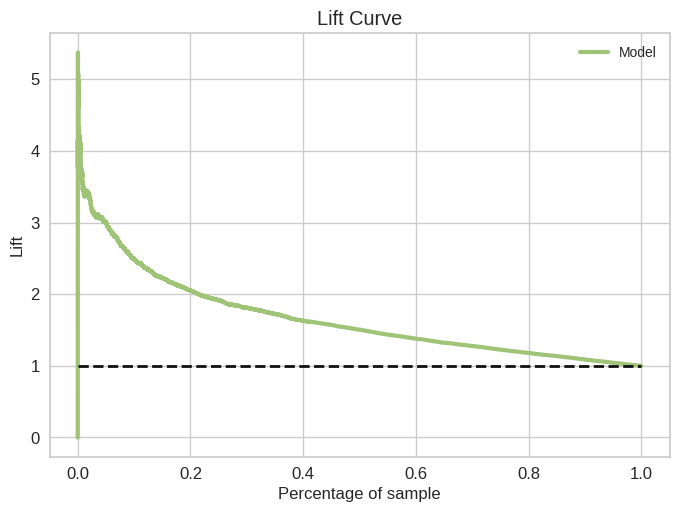

In [24]:
fig, ax = plt.subplots()

skplt.metrics.plot_lift_curve(val_y, model.best_estimator_.predict_proba(val_x), ax=ax) 

lines = ax.get_lines()
for line in lines:
    if line.get_label() == 'Class 0':
        line.remove()

plt.legend(labels=['Model'])

plt.show()

#### ROC Chart

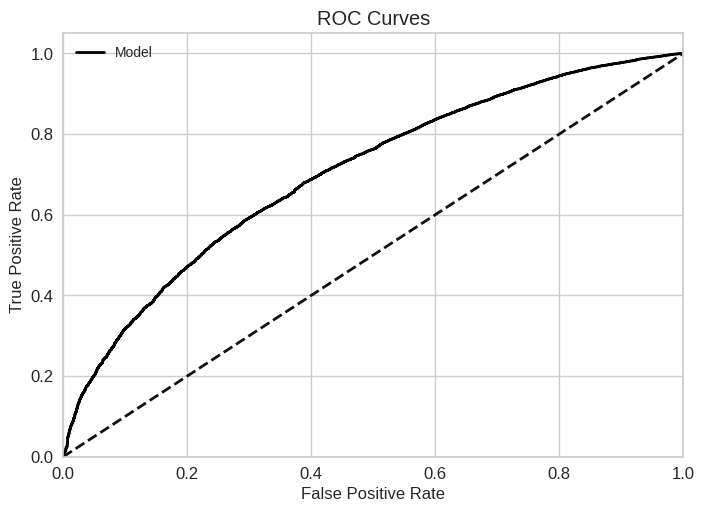

In [25]:
fig, ax = plt.subplots()

skplt.metrics.plot_roc(val_y, model.best_estimator_.predict_proba(val_x), ax=ax)

lines = ax.get_lines()

for line in lines:
    if 'ROC curve of class 0' in line.get_label():
        line.set_label('Model')
    elif line.get_linestyle() != '--':  # Mantenemos la línea punteada pero sin leyenda
        line.set_visible(False)

handles, labels = ax.get_legend_handles_labels()
new_handles = [h for h, l in zip(handles, labels) if l == 'Model']
new_labels = ['Model']

ax.legend(new_handles, new_labels, loc='best')

plt.show();